# Text generator

This notebook contains a simple text generator that predicts the next character based on the previous k characters

In [133]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [134]:
torch.__version__

'2.2.1+cu121'

In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [136]:
device

device(type='cuda')

## Read the text corpus

In [137]:
with open('gt.txt', 'r') as file:
    thefile = file.read()

In [138]:
content = thefile[:-2000]
test = thefile[-2000:]

In [139]:
len(content), len(test)

(567139, 2000)

### Some text in the corpus

In [140]:
content

'PART I. A VOYAGE TO LILLIPUT.\nCHAPTER I.\nThe author gives some account of himself and family. His first inducements to travel. He is shipwrecked, and swims for his life, gets safe on shore in the country of Lilliput; is made a prisoner, and carried up the country.\n\nMy father had a small estate in Nottinghamshire; I was the third of five sons. He sent me to Emanuel College in Cambridge at fourteen years old, where I resided three years, and applied myself close to my studies; but the charge of maintaining me, although I had a very scanty allowance, being too great for a narrow fortune, I was bound apprentice to Mr. James Bates, an eminent surgeon in London, with whom I continued four years. My father now and then sending me small sums of money, I laid them out in learning navigation, and other parts of the mathematics, useful to those who intend to travel, as I always believed it would be, some time or other, my fortune to do. When I left Mr. Bates, I went down to my father: where,

In [141]:
print(type(content))

<class 'str'>


## Create a dictionary to store unique characters and their indices

In [142]:
stoi = {}
stoi['@'] = 0
i = 1
for char in sorted(content):
    if char not in stoi:
        stoi[char] = i
        i+=1

print(stoi)

{'@': 0, '\n': 1, ' ': 2, '!': 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, ':': 19, ';': 20, '?': 21, 'A': 22, 'B': 23, 'C': 24, 'D': 25, 'E': 26, 'F': 27, 'G': 28, 'H': 29, 'I': 30, 'J': 31, 'K': 32, 'L': 33, 'M': 34, 'N': 35, 'O': 36, 'P': 37, 'Q': 38, 'R': 39, 'S': 40, 'T': 41, 'U': 42, 'V': 43, 'W': 44, 'X': 45, 'Y': 46, '[': 47, ']': 48, 'a': 49, 'b': 50, 'c': 51, 'd': 52, 'e': 53, 'f': 54, 'g': 55, 'h': 56, 'i': 57, 'j': 58, 'k': 59, 'l': 60, 'm': 61, 'n': 62, 'o': 63, 'p': 64, 'q': 65, 'r': 66, 's': 67, 't': 68, 'u': 69, 'v': 70, 'w': 71, 'x': 72, 'y': 73, 'z': 74, 'æ': 75, 'œ': 76, '–': 77, '—': 78, '‘': 79, '’': 80, '“': 81, '”': 82}


In [143]:
itos = {value: key for key, value in stoi.items()}

print(itos)

{0: '@', 1: '\n', 2: ' ', 3: '!', 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: '0', 10: '1', 11: '2', 12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8', 18: '9', 19: ':', 20: ';', 21: '?', 22: 'A', 23: 'B', 24: 'C', 25: 'D', 26: 'E', 27: 'F', 28: 'G', 29: 'H', 30: 'I', 31: 'J', 32: 'K', 33: 'L', 34: 'M', 35: 'N', 36: 'O', 37: 'P', 38: 'Q', 39: 'R', 40: 'S', 41: 'T', 42: 'U', 43: 'V', 44: 'W', 45: 'X', 46: 'Y', 47: '[', 48: ']', 49: 'a', 50: 'b', 51: 'c', 52: 'd', 53: 'e', 54: 'f', 55: 'g', 56: 'h', 57: 'i', 58: 'j', 59: 'k', 60: 'l', 61: 'm', 62: 'n', 63: 'o', 64: 'p', 65: 'q', 66: 'r', 67: 's', 68: 't', 69: 'u', 70: 'v', 71: 'w', 72: 'x', 73: 'y', 74: 'z', 75: 'æ', 76: 'œ', 77: '–', 78: '—', 79: '‘', 80: '’', 81: '“', 82: '”'}


## Set the block size

In [144]:
block_size = 15 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for i in range(len(content)-block_size-2):
  X.append([stoi[x] for x in content[i:i+block_size]])
  Y.append(stoi[content[i+block_size]])

# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

### Training data X

In [145]:
X

tensor([[37, 22, 39,  ..., 46, 22, 28],
        [22, 39, 41,  ..., 22, 28, 26],
        [39, 41,  2,  ..., 28, 26,  2],
        ...,
        [64, 64, 53,  ..., 53,  6,  2],
        [64, 53, 52,  ...,  6,  2, 60],
        [53, 52,  2,  ...,  2, 60, 49]], device='cuda:0')

### Training data Y

In [146]:
Y

tensor([26,  2, 41,  ..., 60, 49, 70], device='cuda:0')

In [147]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([567122, 15]), torch.int64, torch.Size([567122]), torch.int64)

## Set the Embedding size

In [148]:
# Embedding layer for the context

emb_dim = 15
emb = torch.nn.Embedding(len(stoi), emb_dim)


In [149]:
emb.weight.shape

torch.Size([83, 15])

## Visualizing the embedding

In [150]:
# # Function to visualize the embedding in 2d space if 2 dimensions are used

# def plot_emb(emb, itos, ax=None):
#     if ax is None:
#         fig, ax = plt.subplots()
#     for i in range(len(itos)):
#         x, y = emb.weight[i].detach().cpu().numpy()
#         ax.scatter(x, y, color='k')
#         ax.text(x + 0.05, y + 0.05, itos[i])
#     return ax

# plot_emb(emb, itos)

## Neural Network Model

In [151]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size1, hidden_size2):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x)) # Activation function : change this
    x = self.lin2(x)
    return x

## Generate text from the untrained model

In [152]:
model = NextChar(block_size, len(stoi), emb_dim, 500, 300).to(device)
model = torch.compile(model)

no_of_chars = 200
g = torch.Generator()
g.manual_seed(200)

def generate_text(model, inp, itos, stoi, block_size, max_len=no_of_chars):

    context = [0] * block_size
    # inp = inp.lower()
    if len(inp) <= block_size:
      for i in range(len(inp)):
        context[i] = stoi[inp[i]]
    else:
      j = 0
      for i in range(len(inp)-block_size,len(inp)):
        context[j] = stoi[inp[i]]
        j+=1

    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        if ix in itos:
          ch = itos[ix]
          name += ch
          context = context[1:] + [ix]
    return name

print(generate_text(model, "@", itos, stoi, block_size, no_of_chars))

yhæIRjVp)FC“YWYh;FzbkEjtz)-z,SEQLYz9v9Owh vk)Ok(
”f:xE,C


### Shapes of model's weights and biases

In [153]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([83, 15])
_orig_mod.lin1.weight torch.Size([500, 225])
_orig_mod.lin1.bias torch.Size([500])
_orig_mod.lin2.weight torch.Size([300, 500])
_orig_mod.lin2.bias torch.Size([300])
_orig_mod.lin3.weight torch.Size([83, 300])
_orig_mod.lin3.bias torch.Size([83])


## Train the model

In [154]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 10
elapsed_time = []
loss_arr = []
for epoch in range(200):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    loss_arr.append(loss.item())
    if epoch % print_every == 0:
        print(epoch, loss.item())


0 1.7106345891952515
10 1.0708658695220947
20 0.9836519956588745
30 0.9446028470993042
40 0.9193400740623474
50 0.9084178805351257
60 0.899061381816864
70 0.8889362215995789
80 0.8820924162864685
90 0.8793640732765198
100 0.87457674741745
110 0.8713557124137878
120 0.8722975850105286
130 0.8752955794334412
140 0.8768930435180664
150 0.8777196407318115
160 0.8777366280555725
170 0.8756823539733887
180 0.8786333203315735
190 0.8764301538467407


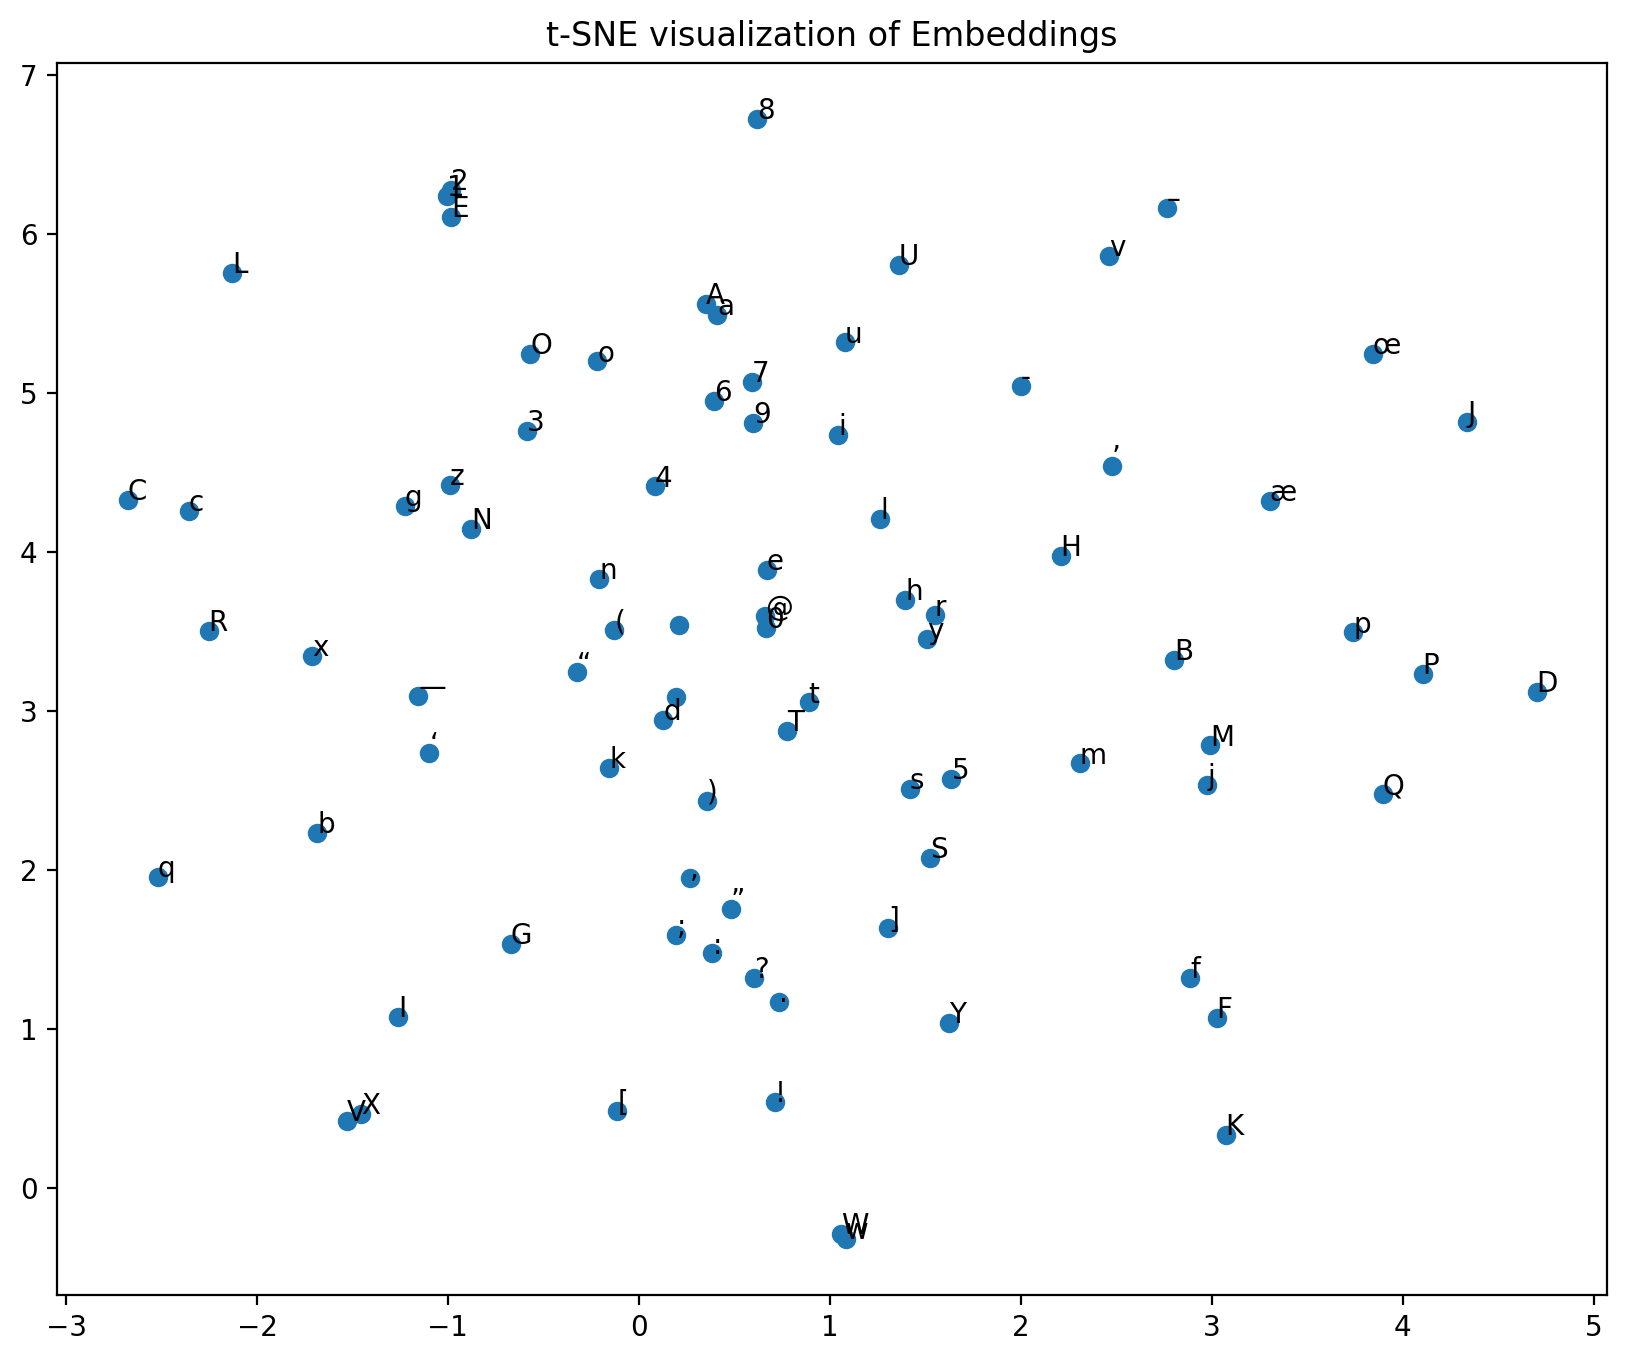

In [156]:
from sklearn.manifold import TSNE
if model.emb.weight.shape[1] > 2:
    embeddings = model.emb.weight.detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i in range(len(itos)):
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], itos[i])
    plt.title('t-SNE visualization of Embeddings')
    plt.show()
else:
    embeddings = model.emb.weight.detach().cpu().numpy()
    if embeddings.ndim == 1:
        plt.figure(figsize=(10, 8))
        for i, emb in enumerate(embeddings):
            plt.scatter(i, emb, color='k')
            plt.text(i + 0.05, emb + 0.05, itos[i])
        plt.title('1D Visualization of Embeddings')
        plt.show()
    else:
        plt.figure(figsize=(10, 8))
        for i in range(len(itos)):
            emb = embeddings[i][0]  # Extracting the single value from the array
            plt.scatter(i, emb, color='k')
            plt.text(i + 0.05, emb + 0.05, itos[i])
        plt.title('2D Visualization of Embeddings')
        plt.show()

## Generate text from the model

In [157]:
print(generate_text(model, "", itos, stoi, block_size, 1000))

ed me to suction I was in the mean.

I to tollood calous me, are in a strang tied mige the metupoced, and our handly they had doIlenend gark and fond, I seems he cansion, I began to folled with the sae younciaens.

My marced to the family with poor people’s drifonts, whose they victure. I obpegaled; that the captain would somple; or my feel, must he assiral leave exercensed about me with loathing to returns I versuased as they ventured stars of been to have)gzt. But the captain’n GOslured; to pacity first Yaxhine, reton and gried one me word hors, having been so rememferate I wanting to a fundatication, I a mede to was the approlers.

Which I eat on the least a Yahoo tock of trivel mation; it withok home I was allel his animals; to return candle Yahoo; but I was go them; cold and cape in pensers. I lone kind a near and cider mistry weat, and I street have bears wently a lord to my private ordered me a wondone they her. It islents of my own country, radions, placest what I .Ky Ip tYHowe

In [158]:
inp_str = "I love travelling around the"
print(inp_str+generate_text(model, inp_str, itos, stoi, block_size, 1000))

I love travelling around their own sais bansarwor, as nevirity. They reason, was desired me “me for work. I reasure, I said they was gave notiouk observe bring was of regrear latting to the astorting someths of what I speak to be so well as I was coight, only are mut nittor of the service it is her lome work; have an excellent me intenah, be weich we tond me will passertife, above vive, migpscadurs I subleratives, activi, as reseland to be is resembled the wilser could not was above imuch is longer, and relawing retrify, ladvering infallish.”

I avotabetenced with and tour name and constinctly they feet with the treast observed every can remost is would itsy-ween to my species of me waiativy desired Yoboeult them; no learning of my coet were. My master, and my master’s preeatius ho reviers; they for so much in the country writing Ytast, The toleo wear, and therefore labourred as I.

“In he had take at the length ownexols, at ladkmys, as mysent doung the like, I meant would servant I wa

Text(0.5, 1.0, 'Loss vs Iterations. Emb size = 15. Block size = 15. 2 hidden layers')

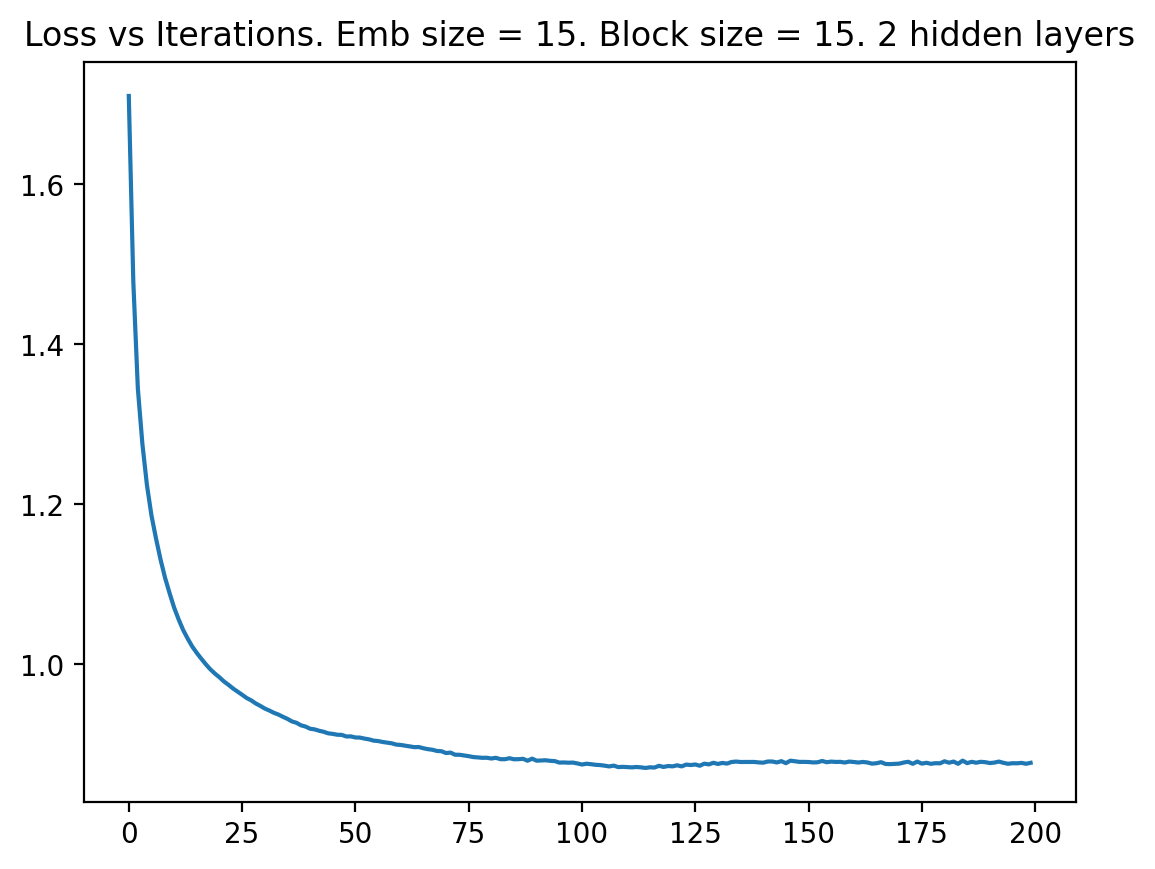

In [159]:
import numpy as np
plt.plot(np.arange(200),loss_arr)
plt.title("Loss vs Iterations. Emb size = 15. Block size = 15. 2 hidden layers")

In [160]:
torch.save(model.state_dict(),"gt_eng_model_upper_two_hid_layer_emb"+str(emb_dim)+"_block_size_"+str(block_size)+".pth")

Tuning knobs

1. Embedding size
2. MLP
3. Context length